# 🤖 3 Training the forecasting model

### 🎯 Objective
The objective of this notebook is to include the needed code to train a forecasting model with the tools you find more suitable for the exercise.
You'll be guided through the notebook, but feel free to add anything you may find interesting to add value to the trained model and its accuracy.

### 🔙 Prerrequisites
1. Make sure you have built and transformed the dataset in previous steps, you'll find notebooks guiding you through this process in this same repository.
2. Install any dependencies you may need, using any dependency manager you like.

In [213]:
import pandas as pd
import shap
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import pickle
import plotly.graph_objects as go

### 🏁 When you finish
Make sure to comment with markdown cells what you have developed to solve this problem. Also, try to explain how to use your code, what we need to install to use it, etc.

## 1. 🔍 Data Loading

Use this part of the notebook to work on: loading the built dataset and splitting in train, validation and test partitions if desired.

### 1.1 💾 Load the dataset.csv file you built in previous steps

In [214]:
df = pd.read_csv('../data/dataset_pp.csv', parse_dates=['DATE'], index_col='DATE')
submission_df = pd.read_csv('../data/submission_dataset_pp.csv', parse_dates=['DATE'], index_col='DATE')

In [215]:
dataset = df.copy()
submission = submission_df.copy()

### 1.2 ✂️ Split your data in partitions

In [216]:
# Train/test split
# Define the split dates
train_end_date = '2017-12-31'
validation_start_date = '2018-01-01'
validation_end_date = '2018-12-31'

# Split the data
train_data = dataset.loc[:train_end_date]
validation_data = dataset.loc[validation_start_date:validation_end_date]

Visualization of the cross validation splits

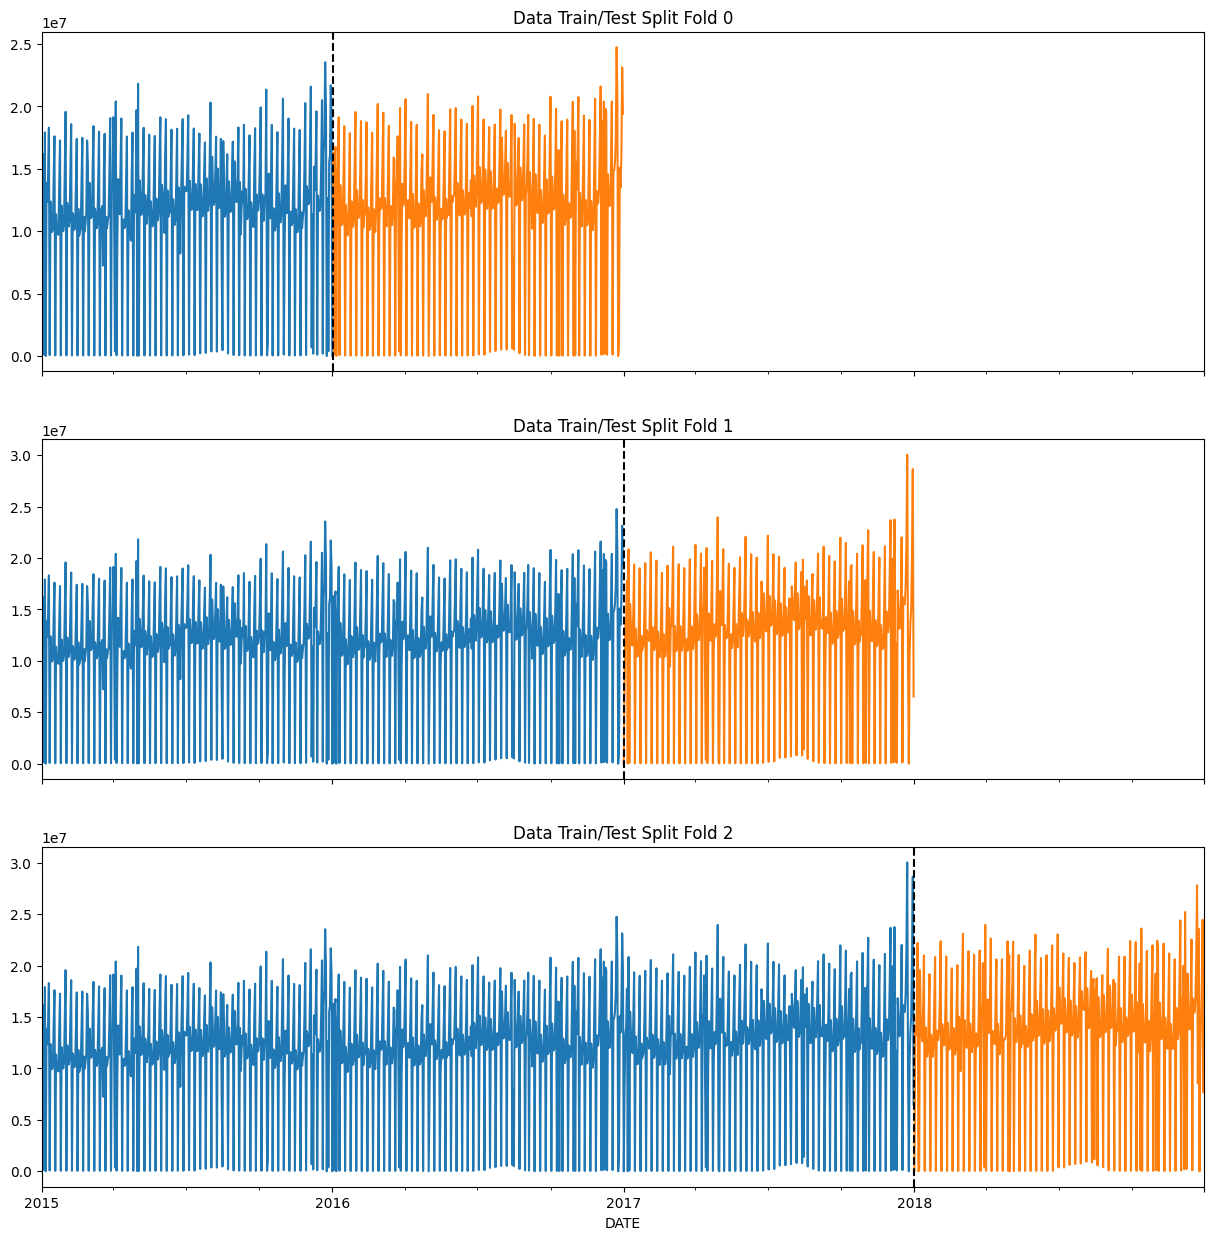

In [217]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)   #, test_size=364
fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tscv.split(dataset):
    train = dataset.iloc[train_idx]
    test = dataset.iloc[val_idx]
    train['SALES'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['SALES'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## 2. 🎯 Feature Selection

Here, you may find useful to select the features you will use for training and the target to forecast. Try to explain why you have selected these features and discarded others.

Remember that the sales column you can find in `data/sales_train_dataset.csv` should be the target variable for your model.

In [218]:
selected_features = [
    # Lag features
    'SALES_LAG_1', 'SALES_LAG_2', 'SALES_LAG_3', 'SALES_LAG_4', 'SALES_LAG_5', 'SALES_LAG_6', 'SALES_LAG_7', 'SALES_LAG_364',
    'sales_roll_mean_7', 'sales_roll_mean_30',
    
    # Date features
    'MONTH', 'WEEKDAY', 'DAY_OF_YEAR', 'DAY_OF_MONTH', 'quarter',
    'is_weekend', 'is_saturday', 'is_sunday', 'is_december',
    
    # Calendar variables
    'num_STATE_A', 'num_STATE_C', 'num_STATE_FA', 'num_STATE_FM', 'num_STATE_CR',
    'stores_open', 'stores_closed',
    'mean_OPENING_TIME_MIN', 'mean_CLOSING_TIME_MIN', 'mean_DURATION_MIN',
    
    # IPC variables
    'IPC_VALUE', 'IPC_LAG_1', 'IPC_LAG_2'
]

# Data for cv and final model (with all the data)
X = dataset[selected_features]
y = dataset['SALES']

# Prepare training and validation datasets
X_train = train_data[selected_features]
y_train = train_data['SALES']

X_valid = validation_data[selected_features]
y_valid = validation_data['SALES']

## 3. 🤖 Modeling

In this section you will declare everything you need to train your model and fit it to your dataset.

I have decided to use LightGBM but other models like [XGBoost](https://xgboost.readthedocs.io/en/stable/) and [Prophet](https://facebook.github.io/prophet/) are really good alternatives. First lets search the best hyperparameters with a gridsearch.

In [219]:
best_params = {}

In [220]:
# Define parameter grid
param_grid = {
    'num_leaves': [20, 31],
    'max_depth': [-1, 20, 30],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 500, 1000],
    'min_split_gain': [0.0, 2.5],
    'min_child_samples': [10, 20, 30]
}
# Instantiate the model
model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

The grid search is disabled to save time by skipping the hyperparameter search process. Set to True and run if you want to perform the search for the best parameters. If the search is skipped, the next cell will attempt to load previously found best parameters.

In [221]:
# Fit the grid search
perform_grid_search = False
if perform_grid_search:
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    print('Best Parameters:', best_params)
else:
    best_params = {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'min_split_gain': 0.0, 'n_estimators': 100, 'num_leaves': 20}
    print(f'Using {best_params} params')

Using {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'min_split_gain': 0.0, 'n_estimators': 100, 'num_leaves': 20} params


Once we have obtained the best parameters lets build a model with the train/validation split

In [222]:
# Train the final model
best_model = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    **best_params
)
best_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4248
[LightGBM] [Info] Number of data points in the train set: 1096, number of used features: 32
[LightGBM] [Info] Start training from score 11898409.088082


LGBMRegressor(learning_rate=0.05, min_child_samples=10, num_leaves=20,
              objective='regression', random_state=42)

Same thing as before but train the model with all the data

In [223]:
complete_model = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    **best_params
)
complete_model.fit(X, y) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4376
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 32
[LightGBM] [Info] Start training from score 12252988.954631


LGBMRegressor(learning_rate=0.05, min_child_samples=10, num_leaves=20,
              objective='regression', random_state=42)

## 4. ✅ Validation

Decide what metric to use to validate the performance of your model and explain why you chose it.

Since I have implemented a model that only predicts the next step, I have proposed two ways to evaluate the validation set. The first approach would be to use all the data and predict only the next step. The alternative is to perform recursive prediction, where the current prediction will be used to predict the next step (through lag variables and rolling means).

I will use the Mean Absolute Error (mae) metric. It measures the average magnitude of errors without considering their direction. It's less sensitive to outliers than Mean Squared Error (MSE). Sales data can have extreme values (e.g., during December). Also, it is a really easy and intuitive metric.

Other really good metric is [Symmetric Mean Absolute Percentage Error (SMAPE)](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)

In [224]:
# Predict on validation set (one step ahead)
y_pred_valid = best_model.predict(X_valid)

# Calculate MAE
mae_one_step = mean_absolute_error(y_valid, y_pred_valid)
print(f'Validation MAE: {mae_one_step}')

Validation MAE: 734579.6503249643


Recursive prediction evaluation

In [225]:
# Prepare for recursive forecasting
validation_dates = validation_data.index
recursive_predictions = []

# Combine training and validation data for lag calculations
combined_data = pd.concat([train_data, validation_data], sort=False)

# Initialize the lag features with actual sales
combined_data['PREDICTED_SALES'] = combined_data['SALES']

# Start recursive forecasting
for current_date in validation_dates:
    # Get the features for the current date
    current_features = combined_data.loc[current_date, selected_features].copy()
    
    # Predict sales for the current date
    current_prediction = best_model.predict(current_features.values.reshape(1, -1))[0]
    
    # Store the prediction
    recursive_predictions.append(current_prediction)
    
    # Update the 'PREDICTED_SALES' column with the prediction
    combined_data.at[current_date, 'PREDICTED_SALES'] = current_prediction
    
    # Update lag features for future dates
    future_dates = combined_data.loc[current_date:].index[1:]  # Dates after current_date
    for lag in [1, 2, 3, 4, 5, 6, 7, 364]:  # For lags 1 to 7 and 364
        lag_feature = f'SALES_LAG_{lag}'
        # Shift the 'PREDICTED_SALES' to create new lag features
        combined_data.loc[future_dates, lag_feature] = combined_data['PREDICTED_SALES'].shift(lag).loc[future_dates]

    # Update rolling means
    combined_data.loc[future_dates, 'sales_roll_mean_7'] = combined_data['PREDICTED_SALES'].rolling(window=7).mean().loc[future_dates]
    combined_data.loc[future_dates, 'sales_roll_mean_30'] = combined_data['PREDICTED_SALES'].rolling(window=30).mean().loc[future_dates]

# After forecasting, calculate MAE
y_pred_recursive = pd.Series(recursive_predictions, index=validation_dates)

# Calculate MAE for recursive forecasting
mae_recursive = mean_absolute_error(y_valid, y_pred_recursive)
print(f'Recursive Forecasting Validation MAE: {mae_recursive}')

Recursive Forecasting Validation MAE: 1045205.3553720523


In [226]:
print(f'Difference in MAE: {mae_recursive - mae_one_step}')

Difference in MAE: 310625.705047088


## 5. 📊 Presentation of Results

If you find it interesting, you can use plots to explain your results, metrics and how your model performance degrades over time.

Also, it may be interesting to write down future work that you think may improve the obtained result.

The graph shows the two prediction versions i have been working with. As can be seen, the recursive prediction worsens as more predictions are made, due to the propagation of error.

In [227]:
# Create traces for actual sales, one-step predictions, and recursive predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=y_valid.index, y=y_valid, mode='lines', name='Actual Sales', line=dict(width=2)))
fig.add_trace(go.Scatter(x=y_valid.index, y=y_pred_valid, mode='lines', name='One-Step Ahead Predictions', line=dict(width=2)))
fig.add_trace(go.Scatter(x=y_valid.index, y=y_pred_recursive, mode='lines', name='Recursive Predictions', line=dict(width=2)))

# Add title and labels
fig.update_layout(
    title='Actual vs Predicted Sales on Validation Set',
    xaxis_title='Date',
    yaxis_title='Sales',
    legend_title='Legend',
    width=900,  # adjust for the figsize equivalent
    height=450
)

# Show the figure
fig.show()

### 5.1 👨🏻‍🏫 Explainability with SHAP

You have explained the results of your trained model using plots and your own words. Now... let's take the next step. We'll be using a library called SHAP, that may help you find insights and explainability on how your model learned the data.

If you haven't heard of SHAP you can find their web site here:

https://shap.readthedocs.io/en/latest/

Don't worry, you will be guided through this exercises.

#### 5.1.1 🐝 Build a Beeswarm plot

Build a Beeswarm plot to help you explain how each feature affects to the output given by the model

In [228]:
shap.initjs()

In [229]:
# compute SHAP values
#explainer = shap.Explainer(complete_model, X)
#shap_values = explainer(X)
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

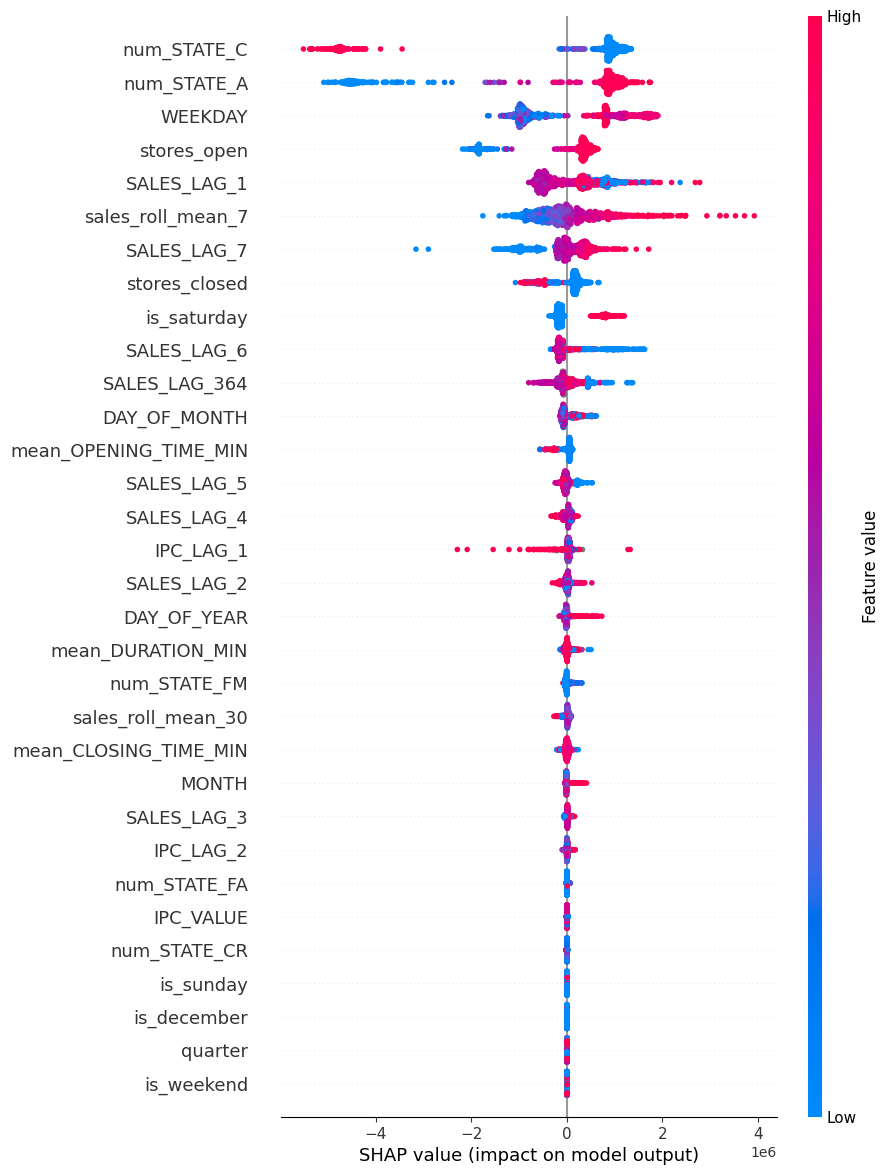

In [230]:
shap.plots.beeswarm(shap_values, max_display=50)

1. **`num_STATE_A` (number of open stores)**: Influential feature. When there are more stores open, the model predicts higher sales (positive SHAP values for high num of open stores), as seen by the red points pushing the SHAP values toward positive predictions.

2. **`num_STATE_C` (number of closed stores)**: Higher values negatively impacting sales predictions. This makes sense since more closed stores would likely lead to lower sales.

3. **`WEEKDAY`**: Certain weekdays likely correlate with higher or lower sales. The wide spread of SHAP values suggests that sales fluctuate significantly (as seen in the exploration notebook).

4. **`stores_open`**: The number of open stores has a direct positive impact on sales. 

5. **Lag Features (`SALES_LAG_1` and `SALES_LAG_7`)**: The model relies on previous sales data, with `SALES_LAG_1` (sales from the previous day) and `SALES_LAG_7` (sales from the same day a week before) showing strong influence.

6. **Rolling means (e.g., `sales_roll_mean_7`)**: The average sales over the past week significantly influence the predictions, especially when the recent trend in sales is high (red), pushing predictions upward.

Other variables like date flags (`is_saturday`, `is_sunday`, `is_weekend`) and IPC related features bear less influence in the sales prediction. 

We can afirm that store operations and recent sales trends are what drives sales predictions in this model.

#### 5.1.2 💪🏻 Build a Force plot

Build a Force plot to help you explain how each feature affects to the output given by the model

In [231]:
shap.plots.force(shap_values[50:100])

In [232]:
shap.plots.force(shap_values[50])

With this plot we can obtain similar conclusions to the beeswarm plot but we can observe single/few instances, lets take one as an example.

The final predicted sales value is **13,858,072.61**. 

- **Positive (Red) Contributions**: 
  - **`WEEKDAY = 4` (Closed stores)**, **`num_STATE_C = 2` (Closed stores)** and **`num_STATE_A = 1516`(Open stores)**, have the largest positive impact.
  - Other features such as **`SALES_LAG_7 = 1.42e+7`(sales from 7 days ago) ** and **`stores_open = 1516`**  also contribute positively but with less impact.
    
- **Negative (Blue) Contributions**: 
  - **`sales_roll_mean_7 = 1.043e+7`** (average sales over the past 7 days) and **`SALES_LAG_1`** have the largest negative impact, pulling the prediction down from the base value.
  - Other features such as **`SALES_LAG_6`** and **`is_saturday`** have minor negative impacts.

- Note: Even though num_STATE_A (only A) and stores_open (A, FA and FM) are equal, they do not represent the same thing.

In summary, open stores and past sales are pushing the prediction higher, while recent sales trends slightly reduce it.

#### 5.1.3 🤷🏻‍♂️ Optional

Explore the SHAP documentation and add any plot you may find useful to explain how the model decides its outputs.

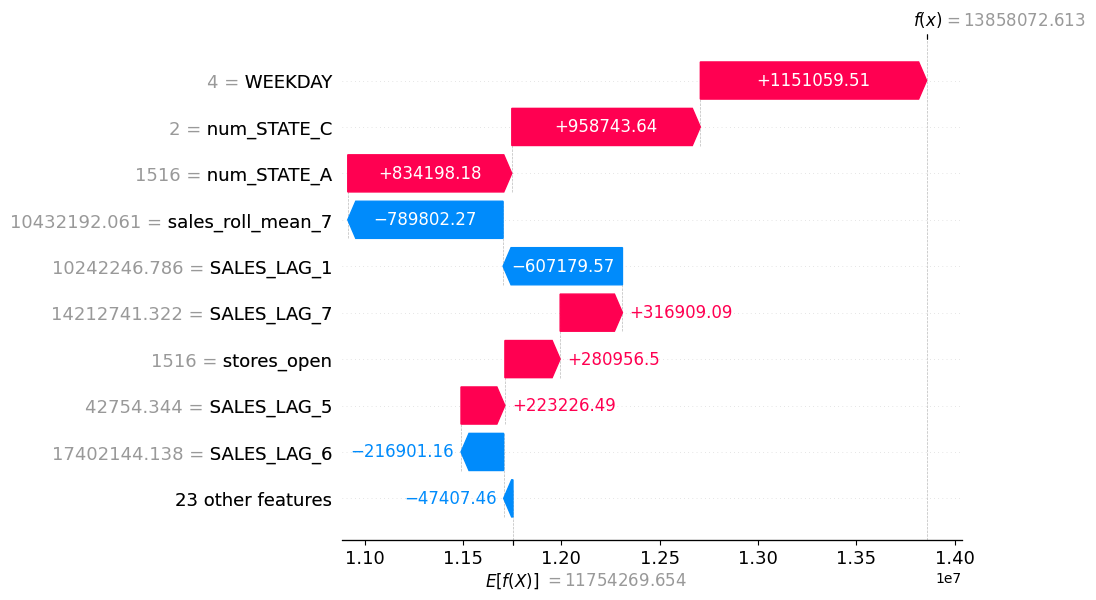

In [233]:
shap.plots.waterfall(shap_values[50])

## 6. 🗃️ Model export

If you have arrived to this point... Congratulations!! 🥳. You trained a working model that can now be served in an API to be used to make predictions.

If you feel like developing a simple REST API to serve your amazing model, continue to the next step you will find in the `app/main.py` file located in this repository.

But first, make sure to export your model to a file you can use to load it in your endpoint.

In [234]:
# Save the model to a file
with open('../app/complete_model.pkl', 'wb') as f:
    pickle.dump(complete_model, f)

## 7.  Submission

Since we are dealing with a one step predictor, we need to prepare a recursive alternative to predict the entire year

In [235]:
# Combine training and submission data for continuity (in order to calculate the lags)
combined_data = pd.concat([X, submission], sort=False)

# Initialize 'PREDICTED_SALES' in combined_data
combined_data['PREDICTED_SALES'] = combined_data['SALES']

# Initialize lag features for the first date (2019-01-01)
first_submission_date = submission.index.min()

for lag in [1, 2, 3, 4, 5, 6, 7, 364]:
    lag_feature = f'SALES_LAG_{lag}'
    lag_date = first_submission_date - pd.Timedelta(days=lag)
    combined_data.loc[first_submission_date, lag_feature] = combined_data.loc[lag_date, 'SALES']

# Initialize rolling means for the first date
combined_data.loc[first_submission_date, 'sales_roll_mean_7'] = combined_data['SALES'].shift(1).rolling(window=7).mean().loc[first_submission_date]
combined_data.loc[first_submission_date, 'sales_roll_mean_30'] = combined_data['SALES'].shift(1).rolling(window=30).mean().loc[first_submission_date]

In [236]:
# Start recursive forecasting
submission_dates = submission.index

for current_date in submission_dates:
    # Update lag features and rolling means for the current date
    for lag in [1, 2, 3, 4, 5, 6, 7, 364]:
        lag_feature = f'SALES_LAG_{lag}'
        lag_date = current_date - pd.Timedelta(days=lag)
        if lag_date in combined_data.index:
            combined_data.loc[current_date, lag_feature] = combined_data.loc[lag_date, 'PREDICTED_SALES']
        else:
            combined_data.loc[current_date, lag_feature] = pd.Na

    # Update rolling means (shift to exclude current day from the calculation)
    combined_data.loc[current_date, 'sales_roll_mean_7'] = combined_data['PREDICTED_SALES'].shift(1).rolling(window=7).mean().loc[current_date]
    combined_data.loc[current_date, 'sales_roll_mean_30'] = combined_data['PREDICTED_SALES'].shift(1).rolling(window=30).mean().loc[current_date]

    # Get the features for the current date
    current_features = combined_data.loc[current_date, selected_features].copy()
    
    # Handle missing values in current_features
    current_features = current_features.fillna(0)

    # Predict sales for the current date
    current_prediction = complete_model.predict(current_features.values.reshape(1, -1))[0]

    # Store the prediction
    submission.at[current_date, 'PREDICTED_SALES'] = current_prediction
    combined_data.at[current_date, 'PREDICTED_SALES'] = current_prediction

In [237]:
# Save the predictions to a CSV file
submission = submission.reset_index()
submission['SALES'] = submission['PREDICTED_SALES']
submission[['DATE', 'SALES']].to_csv('../data/sales_predictions_2019.csv')

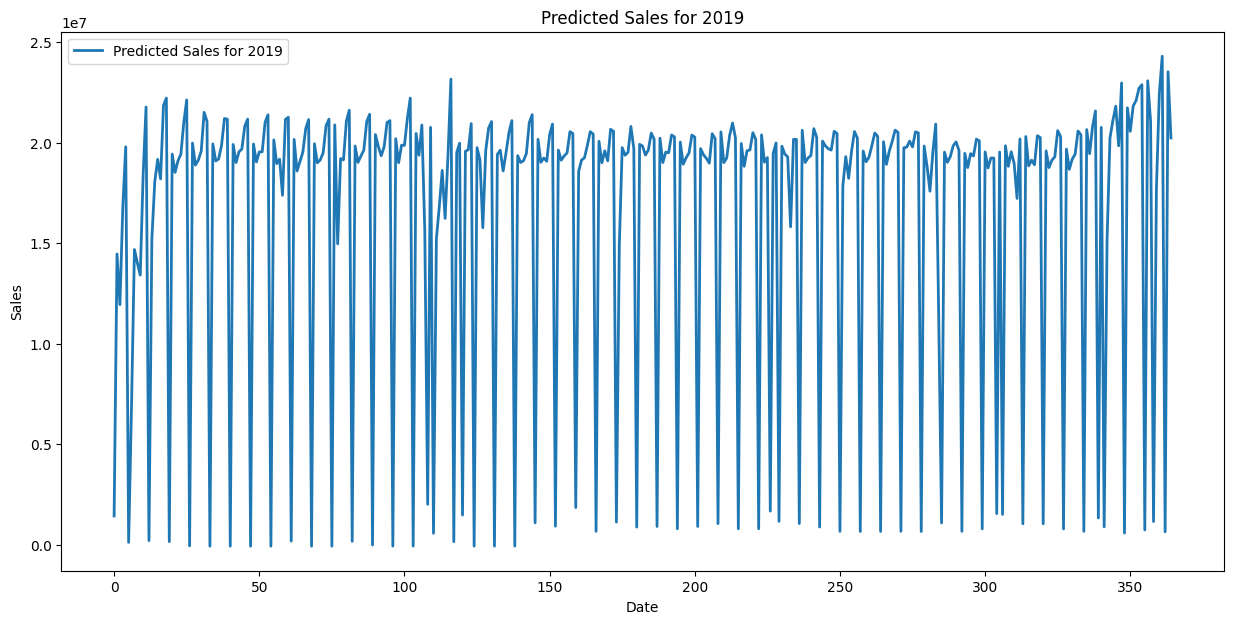

In [238]:
# Plot the predicted sales for 2019
plt.figure(figsize=(15, 7))
plt.plot(submission.index, submission['PREDICTED_SALES'], label='Predicted Sales for 2019', linewidth=2)
plt.title('Predicted Sales for 2019')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()